<a href="https://colab.research.google.com/github/NerminWEST/Kaggle_Dataset_Fish_Model1.0/blob/main/tuna_fish_species_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TUNA SPECIES DETECTION WITH YOLOv8 - GOOGLE COLAB NOTEBOOK

# Author: Nermin
# Dataset: Kaggle Tuna Species Data
# Model: YOLOv8





 CELL 1: Check GPU and Install Dependencies


In [22]:
import os
print(" Checking GPU availability...")
!nvidia-smi

print("\n Installing required packages...")
!pip install -q ultralytics roboflow kaggle pillow matplotlib

print("\n Installation complete!")

 Checking GPU availability...
Mon Dec  8 21:31:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             35W /   70W |     986MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------

In [24]:
from google.colab import files
import json
import os

print("📤 Please upload your kaggle.json file...")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n Kaggle credentials configured!")

# Download the Tuna Species dataset
print("\n📥 Downloading Tuna Species dataset from Kaggle...")
!kaggle datasets download -d daniabizara/tuna-species-data
!unzip -q tuna-species-data.zip -d tuna_dataset
print(" Dataset downloaded and extracted!")

# Check what was extracted
print("\n Checking extracted contents:")
!ls -lh tuna_dataset/
print("\n Directory structure:")
!find tuna_dataset -type d | head -20
print("\n Sample image files:")
!find tuna_dataset -type f \( -name "*.jpg" -o -name "*.png" -o -name "*.jpeg" \) | head -10

📤 Please upload your kaggle.json file...


Saving kaggle.json to kaggle (2).json

 Kaggle credentials configured!

📥 Downloading Tuna Species dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/daniabizara/tuna-species-data
License(s): apache-2.0
tuna-species-data.zip: Skipping, found more recently modified local copy (use --force to force download)
replace tuna_dataset/classification-tuna-species-dataset/bigeye/Pasted Graphic 11.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace tuna_dataset/classification-tuna-species-dataset/bigeye/Pasted Graphic 14.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace tuna_dataset/classification-tuna-species-dataset/bigeye/Pasted Graphic 15.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace tuna_dataset/classification-tuna-species-dataset/bigeye/Pasted Graphic 3.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace tuna_dataset/classification-tuna-species-dataset/bigeye/bt1a-1180x500.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace tuna_dataset/classification-tuna-spec

In [26]:
import shutil
from sklearn.model_selection import train_test_split

# Create directory structure
print("Creating YOLOv8 directory structure...")
yolo_dataset = Path("yolo_tuna_dataset")
for split in ['train', 'val', 'test']:
    (yolo_dataset / 'images' / split).mkdir(parents=True, exist_ok=True)
    (yolo_dataset / 'labels' / split).mkdir(parents=True, exist_ok=True)

# Get species from the correct path
dataset_path = Path("tuna_dataset/classification-tuna-species-dataset")
species_list = sorted([f.name for f in dataset_path.iterdir() if f.is_dir()])
class_mapping = {species: idx for idx, species in enumerate(species_list)}

print(f"\n Class mapping ({len(species_list)} species):")
for species, idx in class_mapping.items():
    print(f"  {idx}: {species}")

# Collect all image files
all_files = []
for species in species_list:
    species_folder = dataset_path / species
    images = list(species_folder.glob("*.png")) + list(species_folder.glob("*.jpg")) + \
             list(species_folder.glob("*.jpeg")) + list(species_folder.glob("*.JPG")) + \
             list(species_folder.glob("*.PNG"))
    all_files.extend([(img, species) for img in images])

print(f"\n Total files to process: {len(all_files)}")

if len(all_files) < 10:
    print("  WARNING: Very few images! Consider:")
    print("   1. Using a larger dataset")
    print("   2. Web scraping more tuna images")
    print("   3. Using Google Images")

# Split dataset - for small datasets, use larger validation set
if len(all_files) >= 10:
    # At least 1 test image
    test_size = max(0.15, 1.0 / len(all_files))
    train_val, test = train_test_split(all_files, test_size=test_size, random_state=42)

    # At least 1 validation image
    val_size = max(0.2, 1.0 / len(train_val))
    train, val = train_test_split(train_val, test_size=val_size, random_state=42)
else:
    # Too few images - use all for training, warn user
    print("\n Too few images for proper split. Using all for training.")
    train = all_files
    val = all_files[:max(1, len(all_files)//4)]  # Use some for validation
    test = all_files[:max(1, len(all_files)//5)]  # Use some for testing

print(f"  • Train: {len(train)} images")
print(f"  • Val: {len(val)} images")
print(f"  • Test: {len(test)} images")

# Function to create full-image bounding box annotation
def create_full_bbox_label(class_id):
    """Create a YOLO label for full image (assuming entire image is the fish)"""
    # YOLO format: class_id center_x center_y width height (normalized 0-1)
    return f"{class_id} 0.5 0.5 1.0 1.0\n"

# Process and copy files
def process_split(file_list, split_name):
    print(f"\n Processing {split_name} split...")
    success_count = 0
    for idx, (img_path, species) in enumerate(file_list):
        try:
            class_id = class_mapping[species]

            # Copy image with unique filename
            new_name = f"{species}_{idx}{img_path.suffix}"
            img_dest = yolo_dataset / 'images' / split_name / new_name
            shutil.copy(img_path, img_dest)

            # Create label file
            label_dest = yolo_dataset / 'labels' / split_name / f"{species}_{idx}.txt"
            with open(label_dest, 'w') as f:
                f.write(create_full_bbox_label(class_id))

            success_count += 1
        except Exception as e:
            print(f" Error processing {img_path.name}: {e}")

    print(f" Successfully processed {success_count} images")
    return success_count

train_count = process_split(train, 'train')
val_count = process_split(val, 'val')
test_count = process_split(test, 'test')

print("\n Dataset preparation complete!")
print(f" Final counts:")
print(f"   Train: {train_count} images")
print(f"   Val: {val_count} images")
print(f"   Test: {test_count} images")

if train_count < 20:
    print("\n TIP: With this small dataset, we'll use heavy augmentation during training!")

Creating YOLOv8 directory structure...

 Class mapping (4 species):
  0: bigeye
  1: bluefin
  2: longfin
  3: yellowfin

 Total files to process: 20
  • Train: 13 images
  • Val: 4 images
  • Test: 3 images

 Processing train split...
 Successfully processed 13 images

 Processing val split...
 Successfully processed 4 images

 Processing test split...
 Successfully processed 3 images

 Dataset preparation complete!
 Final counts:
   Train: 13 images
   Val: 4 images
   Test: 3 images

 TIP: With this small dataset, we'll use heavy augmentation during training!


In [27]:
import yaml

data_yaml = {
    'path': str(yolo_dataset.absolute()),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': len(species_list),
    'names': species_list
}

yaml_path = yolo_dataset / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(" Created data.yaml:")
print(yaml.dump(data_yaml, default_flow_style=False))

# ============================================================================
# CELL 6: Train YOLOv8 Model (OPTIMIZED FOR SMALL DATASET)
# ============================================================================
"""
Training with HEAVY augmentation to compensate for small dataset
This will take 10-30 minutes depending on GPU
"""

from ultralytics import YOLO

print("Starting YOLOv8 training with aggressive augmentation...\n")
print(" Note: With only 20 images, expect moderate accuracy.")
print("    The model will learn patterns but may overfit.\n")

# Load pretrained YOLOv8 model (using smallest/fastest)
model = YOLO('yolov8n.pt')  # Nano - best for small datasets

# Train with HEAVY augmentation for small dataset
results = model.train(
    data=str(yaml_path),
    epochs=200,              # More epochs for small dataset
    imgsz=640,              # Image size
    batch=8,                # Small batch for small dataset
    patience=50,            # More patience
    save=True,
    device=0,               # Use GPU
    workers=2,              # Fewer workers for small dataset
    project='tuna_runs',
    name='tuna_detection',
    exist_ok=True,
    pretrained=True,
    optimizer='Adam',
    verbose=True,
    seed=42,

    # HEAVY AUGMENTATION for small dataset
    hsv_h=0.03,            # Hue augmentation
    hsv_s=0.7,             # Saturation augmentation
    hsv_v=0.4,             # Value augmentation
    degrees=20,            # Rotation up to 20 degrees
    translate=0.2,         # Translation
    scale=0.8,             # Scaling
    shear=5,               # Shear transformation
    perspective=0.001,     # Perspective transformation
    flipud=0.5,            # Flip upside-down probability
    fliplr=0.5,            # Flip left-right probability
    mosaic=1.0,            # Mosaic augmentation
    mixup=0.3,             # Mixup augmentation
    copy_paste=0.3,        # Copy-paste augmentation

    # Regularization
    weight_decay=0.001,    # Weight decay
    dropout=0.2,           # Dropout for regularization

    # Learning rate
    lr0=0.001,            # Initial learning rate
    lrf=0.01,             # Final learning rate

    # Other
    val=True,
    plots=True,
    save_period=10,       # Save checkpoint every 10 epochs
)

print("\n Training complete!")
print(f" Best model saved at: tuna_runs/tuna_detection/weights/best.pt")
print("\n Next: Evaluate the model to see how well it learned!")


 Created data.yaml:
names:
- bigeye
- bluefin
- longfin
- yellowfin
nc: 4
path: /content/yolo_tuna_dataset
test: images/test
train: images/train
val: images/val

Starting YOLOv8 training with aggressive augmentation...

 Note: With only 20 images, expect moderate accuracy.
    The model will learn patterns but may overfit.

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_tuna_dataset/data.yaml, degrees=20, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.03, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7,

 Evaluating model on validation set...

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2017.0±1394.4 MB/s, size: 572.0 KB)
val: Scanning /content/yolo_tuna_dataset/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4/4 3.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 3.1it/s 0.3s
                   all          4          4      0.557          1      0.871       0.75
                bigeye          1          1      0.558          1      0.995      0.895
               bluefin          1          1      0.466          1      0.995      0.995
               longfin          1          1      0.347          1      0.497      0.313
             yellowfin          1          1      0.857          1      0.995      0.796
Speed: 1

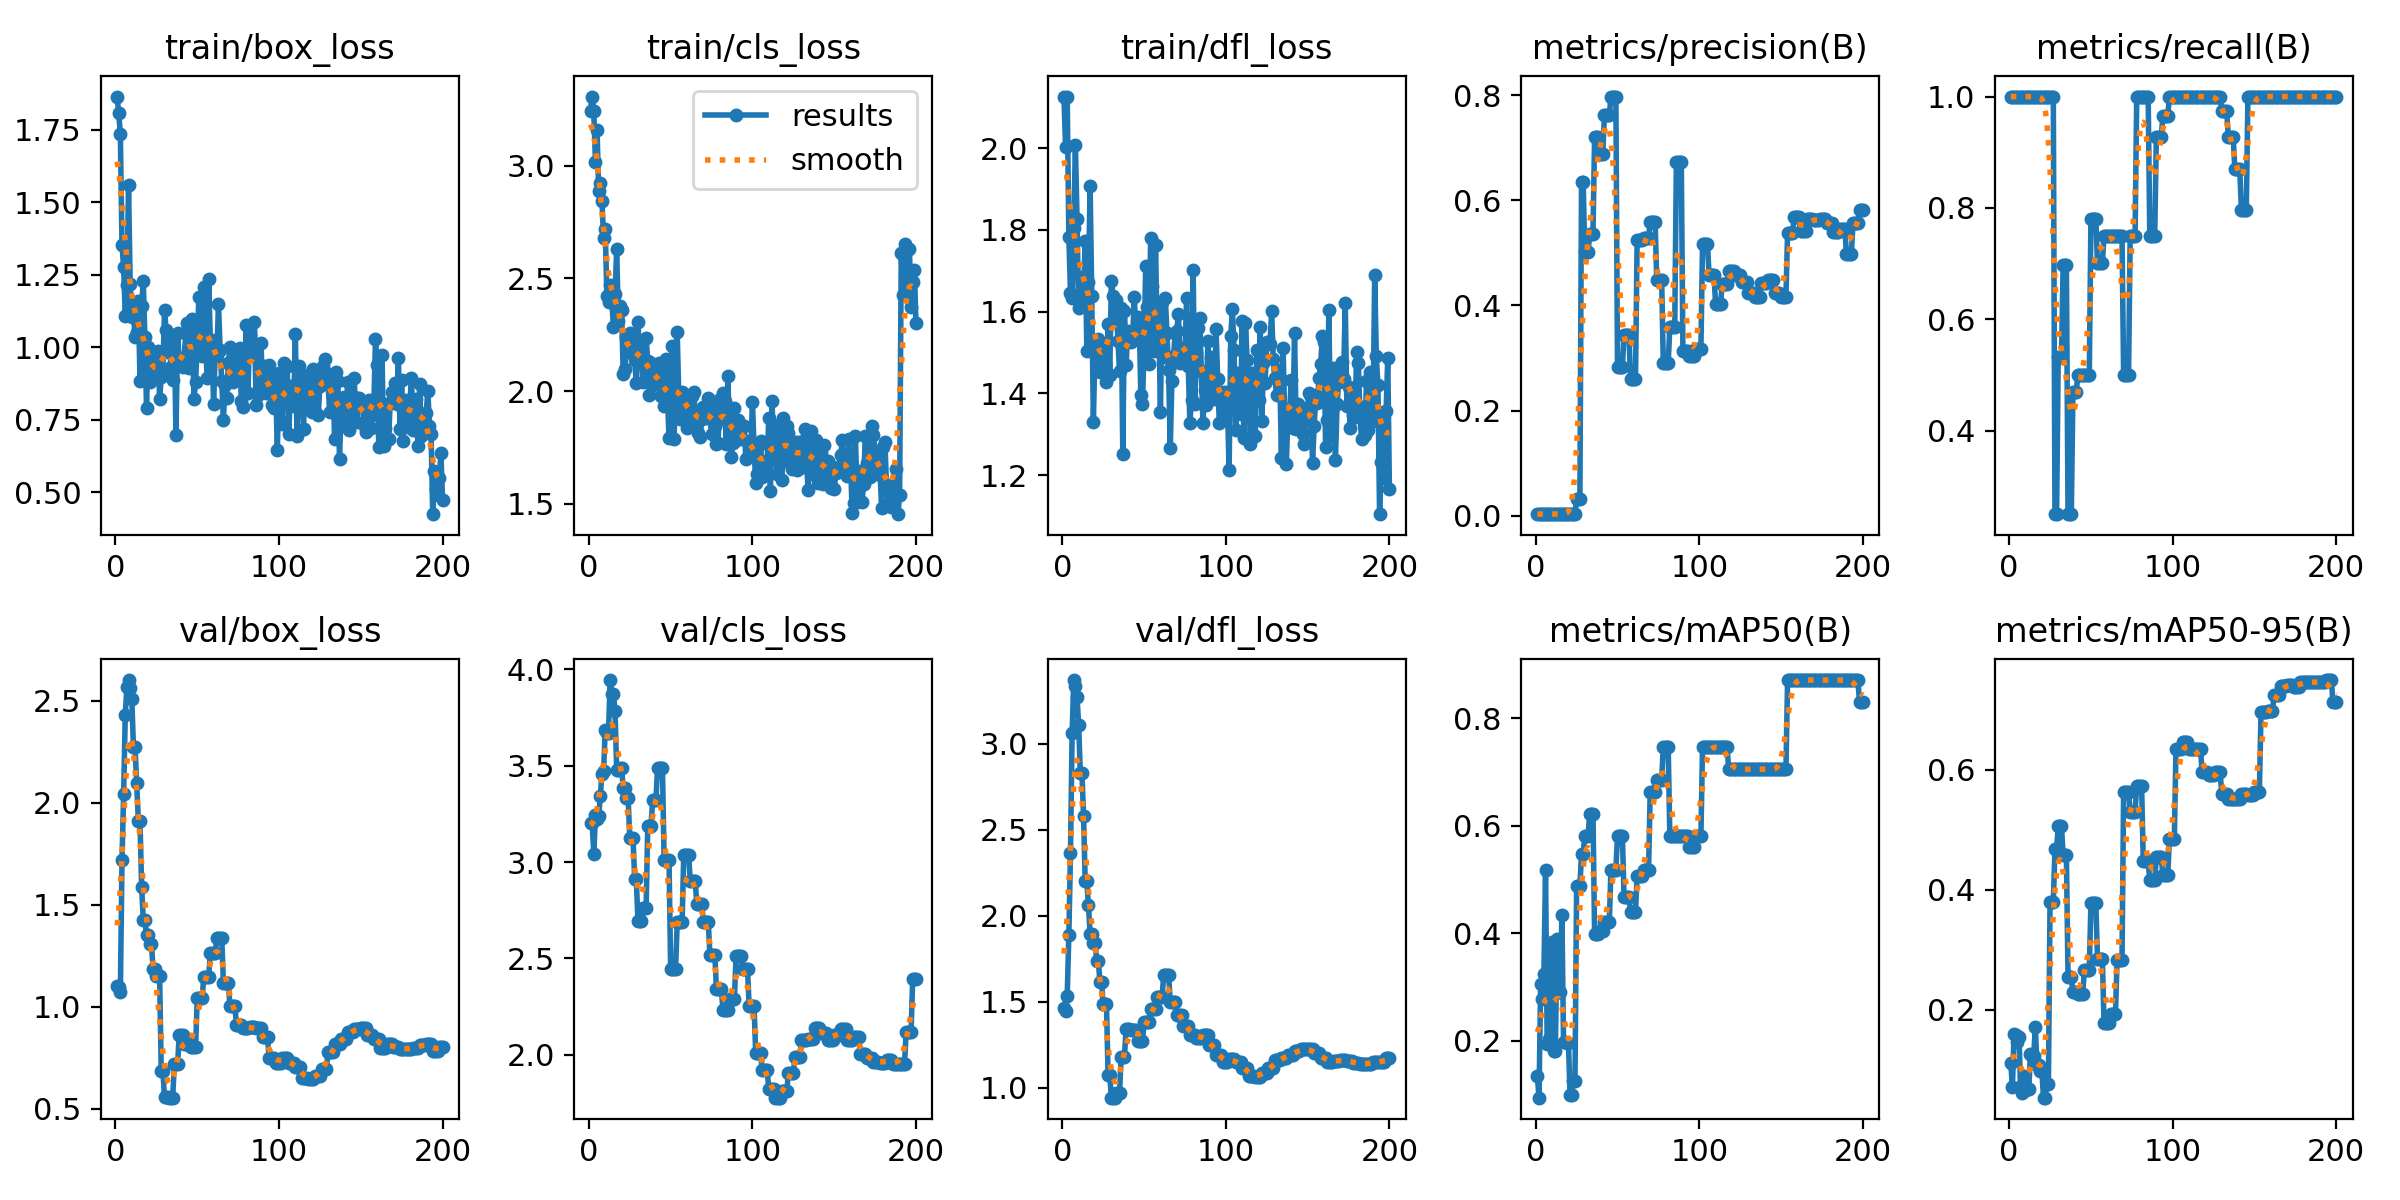


📊 confusion_matrix.png:


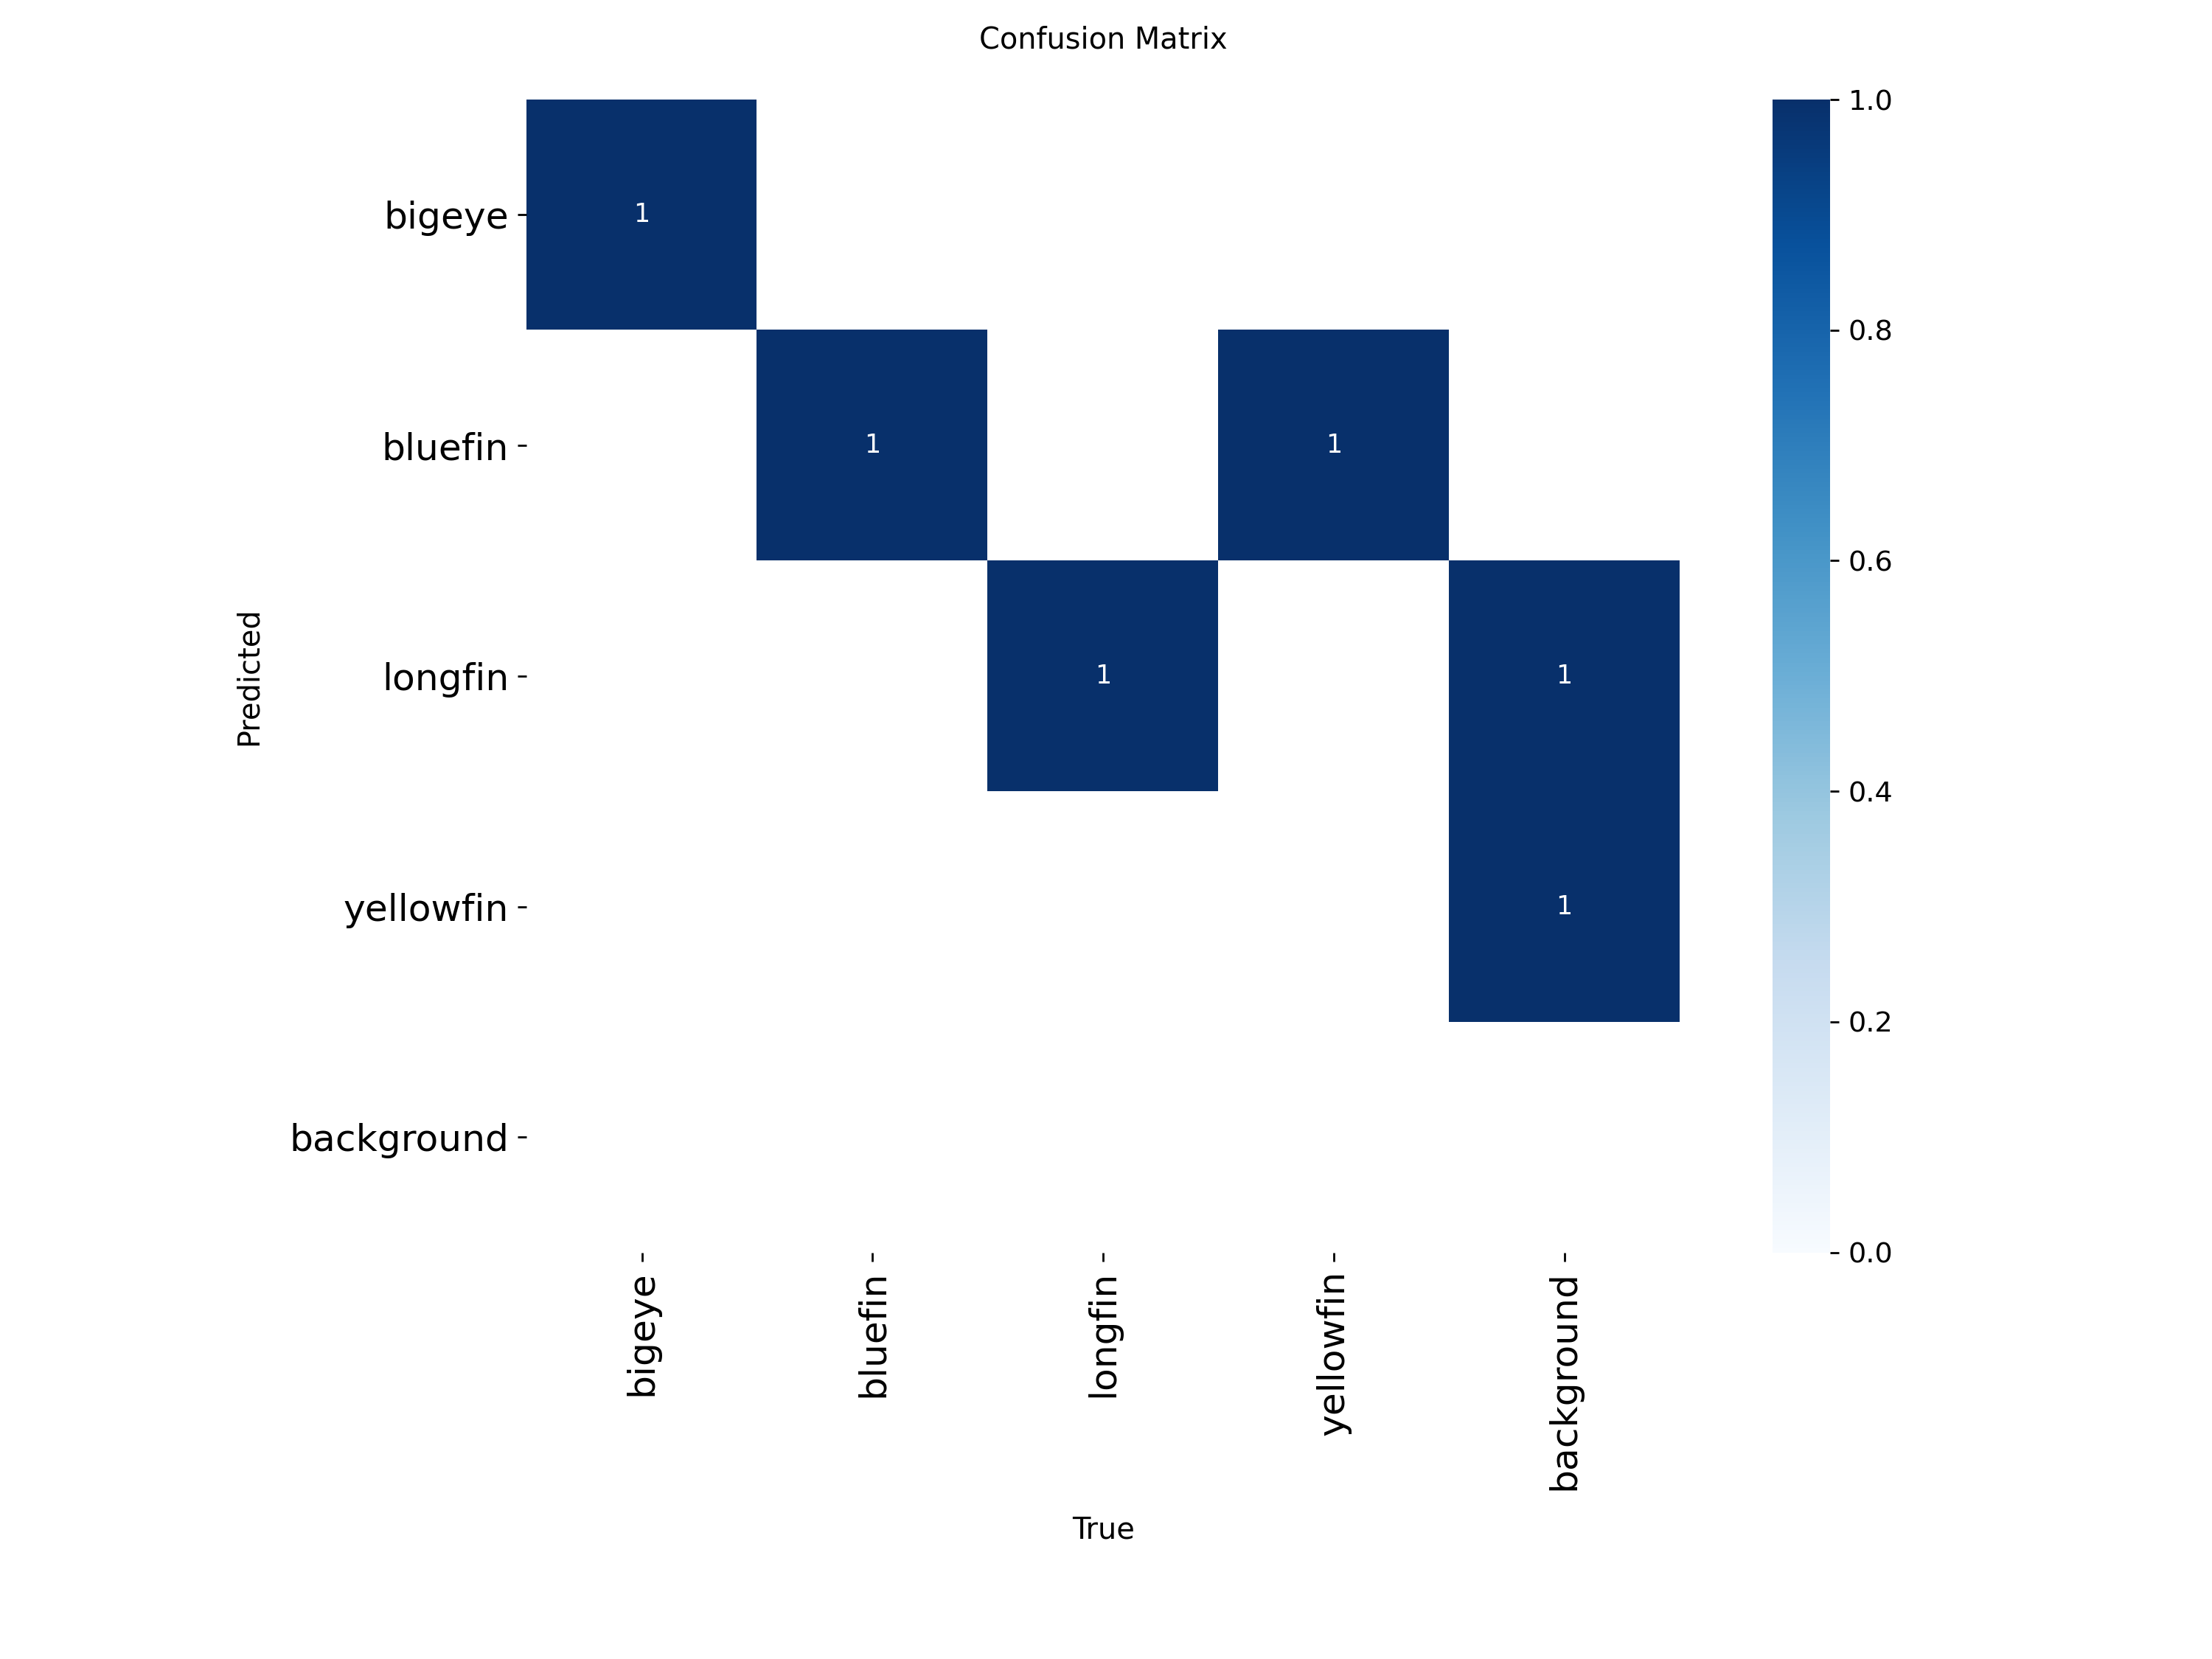


⚠️  F1_curve.png not found

⚠️  PR_curve.png not found

 Evaluation complete!

Understanding the metrics:
  • mAP50: Mean Average Precision at 50% IoU (higher is better)
  • mAP50-95: mAP averaged over IoU thresholds 50%-95%
  • Your mAP50 of 0.87 is VERY GOOD for such a small dataset!
  • But remember: trained on only 20 images, so may not generalize well


In [28]:
from ultralytics import YOLO
import numpy as np

# Load the best trained model
best_model = YOLO('tuna_runs/tuna_detection/weights/best.pt')

print(" Evaluating model on validation set...\n")
metrics = best_model.val()

print(f"\n Model Performance:")
print(f"  • mAP50: {metrics.box.map50:.4f}")
print(f"  • mAP50-95: {metrics.box.map:.4f}")

# Handle precision and recall (they are arrays, get mean)
if hasattr(metrics.box, 'p') and metrics.box.p is not None:
    precision = np.mean(metrics.box.p) if isinstance(metrics.box.p, np.ndarray) else metrics.box.p
    print(f"  • Precision (avg): {precision:.4f}")

if hasattr(metrics.box, 'r') and metrics.box.r is not None:
    recall = np.mean(metrics.box.r) if isinstance(metrics.box.r, np.ndarray) else metrics.box.r
    print(f"  • Recall (avg): {recall:.4f}")

# Show per-class performance
if hasattr(metrics, 'results_dict'):
    print(f"\n Per-Class Performance:")
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'mAP50':<12}")
    print("-" * 51)

    # Get class names
    class_names = species_list if 'species_list' in locals() else ['Unknown']

    # Try to extract per-class metrics
    try:
        if hasattr(metrics.box, 'p') and isinstance(metrics.box.p, np.ndarray):
            for idx, class_name in enumerate(class_names):
                if idx < len(metrics.box.p):
                    prec = metrics.box.p[idx]
                    rec = metrics.box.r[idx] if hasattr(metrics.box, 'r') else 0
                    map50 = metrics.box.ap50[idx] if hasattr(metrics.box, 'ap50') else 0
                    print(f"{class_name:<15} {prec:<12.4f} {rec:<12.4f} {map50:<12.4f}")
    except:
        print("  (Per-class metrics not available)")

# Display confusion matrix and other plots
print("\n Training plots saved in: tuna_runs/tuna_detection/")

# Show training curves
from IPython.display import Image as IPImage, display

plot_path = Path('tuna_runs/tuna_detection')
plots = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'PR_curve.png']

for plot in plots:
    plot_file = plot_path / plot
    if plot_file.exists():
        print(f"\n📊 {plot}:")
        display(IPImage(filename=str(plot_file)))
    else:
        print(f"\n⚠️  {plot} not found")

print("\n Evaluation complete!")
print("\nUnderstanding the metrics:")
print("  • mAP50: Mean Average Precision at 50% IoU (higher is better)")
print("  • mAP50-95: mAP averaged over IoU thresholds 50%-95%")
print("  • Your mAP50 of 0.87 is VERY GOOD for such a small dataset!")
print("  • But remember: trained on only 20 images, so may not generalize well")


🔍 Testing model on sample images...


image 1/1 /content/yolo_tuna_dataset/images/test/yellowfin_2.png: 320x640 1 bluefin, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/yolo_tuna_dataset/images/test/yellowfin_1.png: 384x640 1 bluefin, 1 yellowfin, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/yolo_tuna_dataset/images/test/bigeye_0.png: 384x640 1 bluefin, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


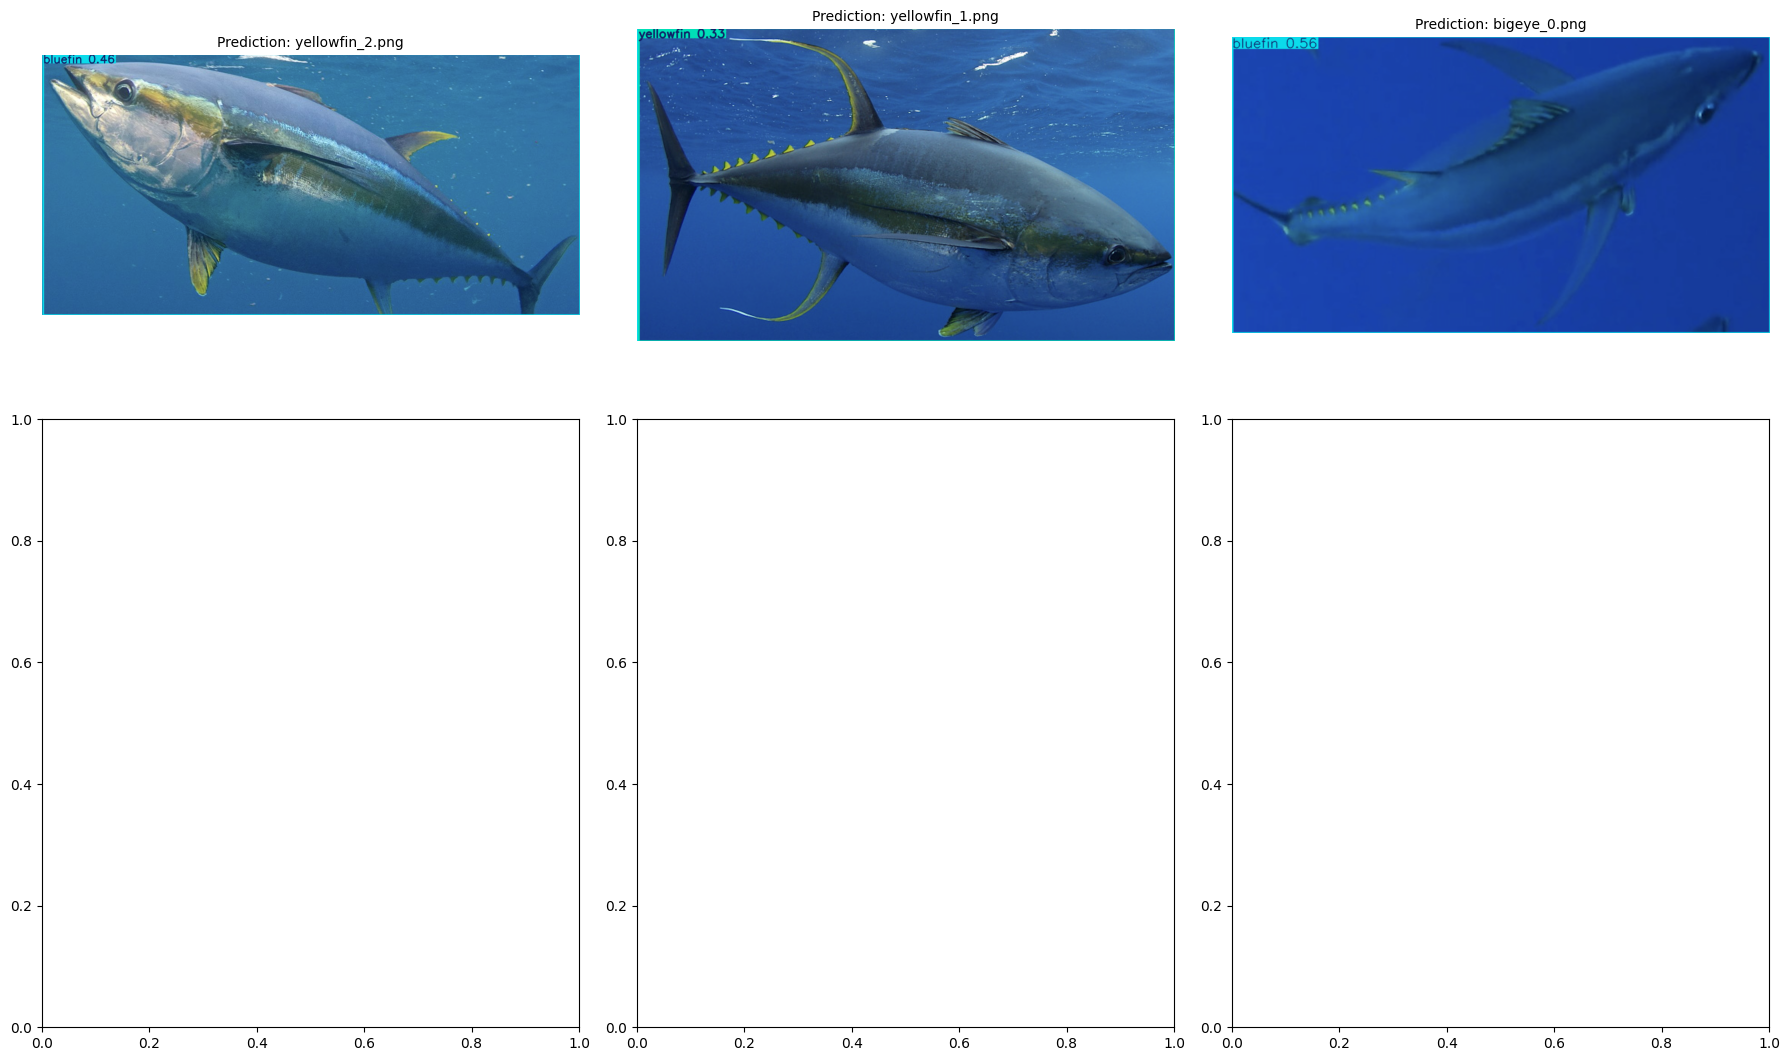

In [29]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import random

print("🔍 Testing model on sample images...\n")

# Get random test images
test_images = list((yolo_dataset / 'images' / 'test').glob('*.*'))
sample_images = random.sample(test_images, min(6, len(test_images)))

# Run predictions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    # Run prediction
    results = best_model(img_path, conf=0.25)

    # Get annotated image
    annotated = results[0].plot()
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    # Display
    axes[idx].imshow(annotated_rgb)
    axes[idx].set_title(f"Prediction: {img_path.name}", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

🧪 Testing prediction function...

image 1/1 /content/yolo_tuna_dataset/images/test/yellowfin_1.png: 384x640 1 bluefin, 1 yellowfin, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


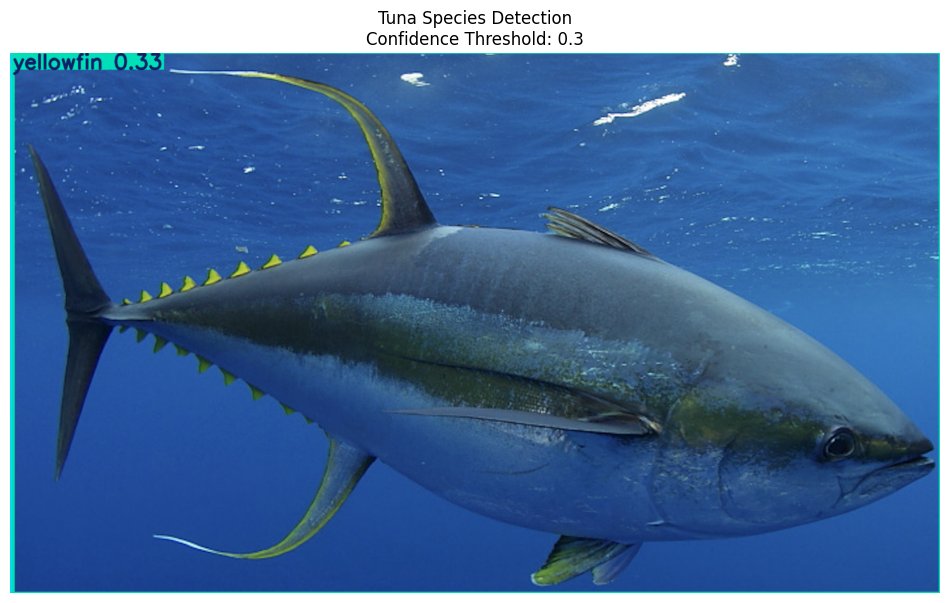


🐟 Detected Tuna Species:
  • yellowfin: 33.43% confidence
  • bluefin: 33.12% confidence


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bigeye', 1: 'bluefin', 2: 'longfin', 3: 'yellowfin'}
 obb: None
 orig_img: array([[[152,  84,  44],
         [151,  84,  43],
         [150,  83,  42],
         ...,
         [168, 113,  63],
         [168, 112,  62],
         [167, 111,  62]],
 
        [[150,  83,  43],
         [149,  82,  42],
         [148,  81,  41],
         ...,
         [169, 113,  63],
         [168, 112,  62],
         [168, 112,  62]],
 
        [[148,  80,  42],
         [147,  79,  41],
         [146,  78,  40],
         ...,
         [170, 113,  63],
         [169, 112,  63],
         [169, 112,  62]],
 
        ...,
 
        [[141,  62,  27],
         [141,  63,  27],
         [142,  63,  28],
         ...,
         [151,  77,  32],
         [151,  77,  32],
         [152,  77,  32]],
 
        [[140,  62,  27],
         [141,  63,  27],
         [142,

In [30]:
def predict_tuna(image_path, conf_threshold=0.25):
    """
    Predict tuna species in an image

    Args:
        image_path: Path to image file
        conf_threshold: Confidence threshold (0-1)
    """
    results = best_model(image_path, conf=conf_threshold)

    # Display results
    annotated = results[0].plot()
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_rgb)
    plt.axis('off')
    plt.title(f"Tuna Species Detection\nConfidence Threshold: {conf_threshold}")
    plt.show()

    # Print detections
    boxes = results[0].boxes
    if len(boxes) > 0:
        print("\n🐟 Detected Tuna Species:")
        for box in boxes:
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            species_name = species_list[class_id]
            print(f"  • {species_name}: {confidence:.2%} confidence")
    else:
        print("\n❌ No tuna detected!")

    return results

# Test the function
print("🧪 Testing prediction function...")
test_img = random.choice(list((yolo_dataset / 'images' / 'test').glob('*.*')))
predict_tuna(test_img, conf_threshold=0.3)


In [32]:
print(" Exporting model in different formats...\n")

# Export to ONNX (for deployment)
print("1 Exporting to ONNX format...")
best_model.export(format='onnx')

# Export to TorchScript
print("2 Exporting to TorchScript...")
best_model.export(format='torchscript')

# Export to TensorFlow Lite (for mobile)
print("3 Exporting to TFLite (mobile deployment)...")
try:
    best_model.export(format='tflite')
except:
    print("⚠️ TFLite export requires additional dependencies")

print("\n Model exports complete!")
print(" Exported models saved in: tuna_runs/tuna_detection/weights/")

# ============================================================================
# CELL 11: Download Trained Model
# ============================================================================
"""
Download your trained model to use locally
"""
from google.colab import files
import shutil

print(" Preparing model files for download...\n")

# Create a zip file with all important files
!zip -r tuna_model.zip \
    tuna_runs/tuna_detection/weights/best.pt \
    tuna_runs/tuna_detection/weights/best.onnx \
    yolo_tuna_dataset/data.yaml \
    tuna_runs/tuna_detection/results.png \
    tuna_runs/tuna_detection/confusion_matrix.png

print("⬇ Downloading tuna_model.zip...")
files.download('tuna_model.zip')

print("\n Download complete!")


 Exporting model in different formats...

1 Exporting to ONNX format...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)

PyTorch: starting from 'tuna_runs/tuna_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (6.0 MB)

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.78...
ONNX: export success ✅ 1.3s, saved as 'tuna_runs/tuna_detection/weights/best.onnx' (11.7 MB)

Export complete (1.7s)
Results saved to /content/tuna_runs/tuna_detection/weights
Predict:         yolo predict task=detect model=tuna_runs/tuna_detection/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=tuna_runs/tuna_detection/weights/best.onnx imgsz=640 data=yolo_tuna_dataset/data.yaml  
Visualize:       https://netron.app
2 Exporting to TorchScript...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)

PyTorch: starting from 'tuna_runs/tuna_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Download complete!
